
# Smart Garbage Classification using MobileNetV2
This notebook classifies images of trash using transfer learning with **MobileNetV2**. The model distinguishes between cardboard, glass, metal, paper, plastic, and general trash using improved data augmentation and training strategies.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:

train_path = r'C:/Users/DELL/OneDrive/Documents/Garbage Classification/TrashType_Image_Dataset/train'
test_path = r'C:/Users/DELL/OneDrive/Documents/Garbage Classification/TrashType_Image_Dataset/test'


In [3]:

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_ds = test_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

class_names = list(train_ds.class_indices.keys())
print("Classes:", class_names)


Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_ds.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)         ┃ Output Shape       ┃    Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_layer          │ (None, 224, 224,   │          0 │ -                  │
│ (InputLayer)         │ 3)                 │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ Conv1 (Conv2D)       │ (None, 112, 112,   │        864 │ input_layer[0][0]  │
│                      │ 32)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ bn_Conv1             │ (None, 112, 112,   │        128 │ Conv1[0][0]        │
│ (BatchNormalization) │ 32)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ Conv1_relu (ReLU)    │ (None, 112, 112,   │          0 │ bn_Conv1[0][0]     │
│                      │ 32)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ expanded_conv_depth… │ (None, 112, 112,   │        288 │ Conv1_relu[0][0]   │
│ (DepthwiseConv2D)    │ 32)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ expanded_conv_depth… │ (None, 112, 112,   │        128 │ expanded_conv_dep… │
│ (BatchNormalization) │ 32)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ expanded_conv_depth… │ (None, 112, 112,   │          0 │ expanded_conv_dep… │
│ (ReLU)               │ 32)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ expanded_conv_proje… │ (None, 112, 112,   │        512 │ expanded_conv_dep… │
│ (Conv2D)             │ 16)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ expanded_conv_proje… │ (None, 112, 112,   │         64 │ expanded_conv_pro… │
│ (BatchNormalization) │ 16)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ block_1_expand       │ (None, 112, 112,   │      1,536 │ expanded_conv_pro… │
│ (Conv2D)             │ 96)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ block_1_expand_BN    │ (None, 112, 112,   │        384 │ block_1_expand[0]… │
│ (BatchNormalization) │ 96)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ block_1_expand_relu  │ (None, 112, 112,   │          0 │ block_1_expand_BN… │
│ (ReLU)               │ 96)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ block_1_pad          │ (None, 113, 113,   │          0 │ block_1_expand_re… │
│ (ZeroPadding2D)      │ 96)                │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ block_1_depthwise    │ (None, 56, 56, 96) │        864 │ block_1_pad[0][0]  │
│ (DepthwiseConv2D)    │                    │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ block_1_depthwise_BN │ (None, 56, 56, 96) │        384 │ block_1_depthwise… │
│ (BatchNormalization) │                    │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ block_1_depthwise_r… │ (None, 56, 56, 96) │          0 │ block_1_depthwise… │
│ (ReLU)               │                    │            │                    │


 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ModelCheckpoint("garbage_classifier_using_mobilenet.keras", save_best_only=True)
]


In [6]:

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=callbacks
)


C:\Users\DELL\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.4628 - loss: 1.4506 - val_accuracy: 0.7362 - val_loss: 0.6958
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7039 - loss: 0.7663 - val_accuracy: 0.7795 - val_loss: 0.6377
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7426 - loss: 0.6959 - val_accuracy: 0.7854 - val_loss: 0.6345
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7578 - loss: 0.6086 - val_accuracy: 0.7835 - val_loss: 0.6092
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7823 - loss: 0.6214 - val_accuracy: 0.8169 - val_loss: 0.5280
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7997 - loss: 0.5460 - val_accuracy: 0.7913 - val_loss: 0.5569
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7887 - loss: 0.5488 - val_accuracy: 0.8228 - val_loss: 0.5393
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8138 - loss: 0.5202 - val_accuracy: 0.8091 - val

In [7]:
# Unfreeze the top 30 layers
for layer in model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Compile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for 5–10 more epochs
fine_tune_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8492 - loss: 0.3818 - val_accuracy: 0.8445 - val_loss: 0.4582
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8683 - loss: 0.3772 - val_accuracy: 0.8425 - val_loss: 0.4709
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8912 - loss: 0.3214 - val_accuracy: 0.8465 - val_loss: 0.4547
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8624 - loss: 0.3582 - val_accuracy: 0.8366 - val_loss: 0.4654
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8868 - loss: 0.3130 - val_accuracy: 0.8484 - val_loss: 0.4642
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8856 - loss: 0.3089 - val_accuracy: 0.8406 - val_loss: 0.4560
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8815 - loss: 0.3067 - val_accuracy: 0.8524 - val_loss: 0.4541
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8879 - loss: 0.3050 - val_accuracy: 0.8563 - v

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 960ms/step


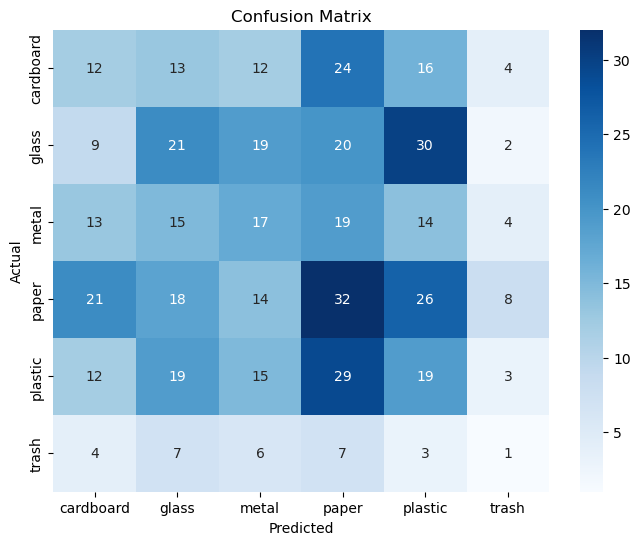


Classification Report:

              precision    recall  f1-score   support

   cardboard       0.17      0.15      0.16        81
       glass       0.23      0.21      0.22       101
       metal       0.20      0.21      0.21        82
       paper       0.24      0.27      0.26       119
     plastic       0.18      0.20      0.19        97
       trash       0.05      0.04      0.04        28

    accuracy                           0.20       508
   macro avg       0.18      0.18      0.18       508
weighted avg       0.20      0.20      0.20       508



In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_true = test_ds.classes
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


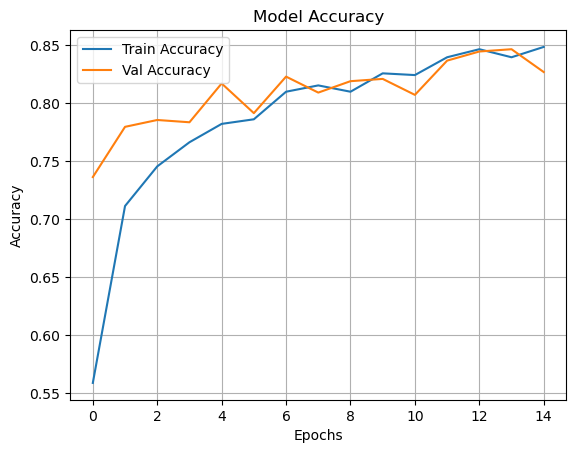

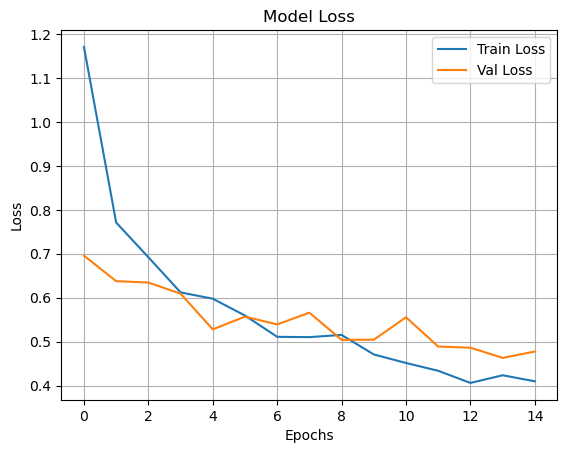

In [9]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:

loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

model.save("garbage_classifier_using_mobilenet.keras")
print("Model saved as 'garbage_classifier_using_mobilenet.keras'")


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 876ms/step - accuracy: 0.8566 - loss: 0.4660
Test Accuracy: 0.8583, Test Loss: 0.4428
Model saved as 'garbage_classifier_using_mobilenet.keras'
